## Construction of reference trajectory
### Step2. In this notebook, we will calculate the pseudotime of NaiveB and GCB cells within mature TLS to construct the developmental trajectory of NaiveB

In [1]:
suppressMessages({library(monocle3)
library(Seurat)
library(SeuratWrappers)
library(patchwork)
library(dplyr)
library(ggplot2)
library(glue)
library(Matrix)
library(cowplot)
library(future)
options(future.globals.maxSize = 30 * 1024^3)})

In [2]:
# Load Mature TLS seurat object
obj_merged <- readRDS('/data/yuchen_data/Stereo_seq/All_Figures/Tls_classification/1.data/Mature.NaiveGCB.rds')
obj_merged

An object of class Seurat 
33168 features across 2601 samples within 1 assay 
Active assay: Spatial (33168 features, 0 variable features)
 10 images present: slice1, slice1.1, slice1.2, slice1.3, slice1.4, slice1.5, slice1.6, slice1.7, slice1.8, slice1.9

In [3]:
# add SPRING embedding to the seurat object
df_coor = read.csv('/data/yuchen_data/Stereo_seq/All_Figures/Tls_classification/1.data/Harmony_Mature.df_coor_k21.txt', row.names=1, header=T, sep='\t')
df_coor = df_coor[row.names(obj_merged@meta.data), ]
df = df_coor[, c('x', 'y')]
colnames(df) = c('UMAP_1', 'UMAP_2')
print(head(df))
knn_reduction = CreateDimReducObject(embeddings = as.matrix(df), assay='Spatial', key='UMAP')
obj_merged@reductions[['UMAP']] = knn_reduction

                     UMAP_1    UMAP_2
ST2740P_BIN.136908 559.6815  99.90709
ST2740P_BIN.137428 731.0058  89.20280
ST2740P_BIN.137429 754.7517  95.93902
ST2740P_BIN.137430 804.3766 142.42311
ST2740P_BIN.137431 785.3427 124.09223
ST2740P_BIN.137433 774.4943 181.53035


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from UMAP to UMAP_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to UMAP_”


In [4]:
# use monocle3 to calculate pseudotime based on the SPRING embedding
# convert seurat object to monocle3 object
obj_cds <- as.cell_data_set(obj_merged)

In [5]:
# clustering and learn graph
obj_cds <- cluster_cells(cds = obj_cds, reduction_method = "UMAP", k=20, cluster_method="leiden", resolution=0.001, num_iter=2)

In [6]:
obj_cds <- learn_graph(obj_cds, use_partition = F, learn_graph_control = list(minimal_branch_len=8, rann.k=5))

  |======================================================================| 100%


Warning message in igraph::graph.dfs(stree_ori, root = root_cell, neimode = "all", :
“Argument `neimode' is deprecated; use `mode' instead”


In [7]:
# because the GCB cells were mainly aggregated in the upright, so we choose the leftmost cell as the root cell 
start_cell = row.names(df)[order(df$UMAP_1, decreasing=F)[1]]
obj_cds <- order_cells(obj_cds, root_cells=start_cell)

Cells aren't colored in a way that allows them to be grouped.



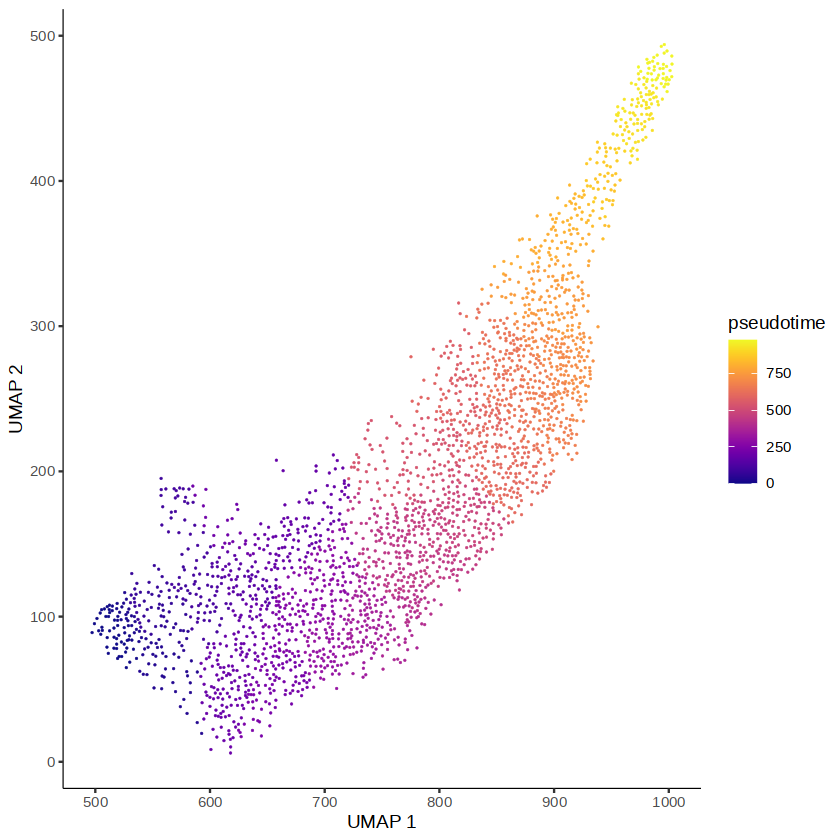

In [8]:
plot_cells(
cds = obj_cds,
color_cells_by = "pseudotime",
show_trajectory_graph = F
)

In [11]:
# we can save the pseudotime and expression of each naiveB and GCB cells
pseu_time <- obj_cds@principal_graph_aux@listData$UMAP$pseudotime
head(pseu_time)
write.table(pseu_time, '/data/yuchen_data/Stereo_seq/All_Figures/Tls_classification/1.data/NaiveB_GC_trajectory_pseudotime.txt', sep='\t')

write.table(obj_merged@assays$Spatial@counts, '/data/yuchen_data/Stereo_seq/All_Figures/Tls_classification/1.data/NaiveB_GCB_count.txt', sep='\t', quote=F)

ST2740P_BIN.136908 ST2740P_BIN.137428 ST2740P_BIN.137429 ST2740P_BIN.137430 
           49.7604           336.8496           348.9890           445.9916 
ST2740P_BIN.137431 ST2740P_BIN.137433 
          443.1405           534.1628

In [9]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/yuchen/miniconda3/envs/jupyter/lib/libopenblasp-r0.3.23.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future_1.32.0               cowplot_1.1.1              
 [3] Matrix_1.5-4.1              glue_1.6.2                 
 [5] ggplot2_3.4.2               dplyr_1.1.2                
 [7] patchwork_1.1.2             SeuratWrappers_0.3.1       
 [9] SeuratObject_4.1.3          Seurat_4.